In [1]:
import cv2
import numpy as np
from matplotlib.pyplot import imshow
import os
%matplotlib inline
import csv

In [2]:
def get_intersect_area(comp_A,comp_B):
    A_x, A_y, A_w, A_h = comp_A
    B_x, B_y, B_w, B_h = comp_B
    in_x1 = max(A_x, B_x)
    in_x2 = min(A_x+A_w, B_x+B_w)
    in_w = in_x2 - in_x1

    in_y1 = max(A_y, B_y)
    in_y2 = min(A_y+A_h, B_y+B_h)
    in_h = in_y2 - in_y1

    if (in_w < 0 or in_h < 0):
        interArea = 0
    else:
        interArea = in_w * in_h
        
    return interArea

def get_union_area(comp_A,comp_B):
    A_x, A_y, A_w, A_h = comp_A
    B_x, B_y, B_w, B_h = comp_B
    
    unionArea = A_w * A_h + B_w * B_h - get_intersect_area(comp_A,comp_B)
    
    return unionArea

def get_distance(center_A,center_B):
    A_x, A_y=center_A
    B_x, B_y=center_B
    
    return np.sqrt((A_x-B_x)**2+(A_y-B_y)**2)

def get_marginal_xywh(xywh,margin_wh,image_wh):
    box_x,box_y,box_w,box_h = xywh
    margin_w,margin_h = margin_wh
    img_w,img_h = image_wh
    
    center_x = box_x+box_w/2
    center_y = box_y+box_h/2
    
    x = max(box_x-margin_w,0)
    y = max(box_y-margin_h,0)
    
    if box_x+box_w+margin_w >= img_w:
        w = img_w - x - 1
    else:
        w = box_x+box_w+margin_w - x -1
        
    if box_y+box_h+margin_h >= img_h:
        h = img_h - y -1
    else:
        h = box_y+box_h+margin_h -y -1
    return [int(x),int(y),int(w),int(h)]
    

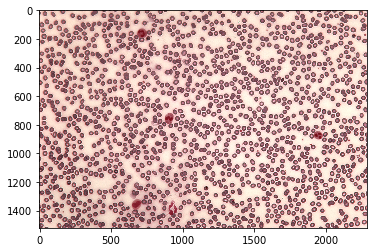

In [3]:
img = cv2.imread('/home/junhyun/CT_20/TEST19.png')
imshow(img)

In [4]:
img_B = img[:,:,0]
img_R = img[:,:,2]
I_1 = img_R-img_B

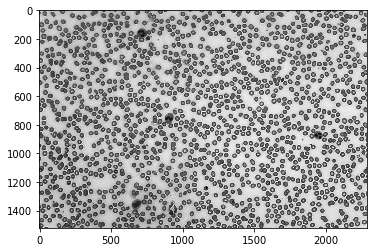

In [5]:
imshow(img_R,cmap='gray')

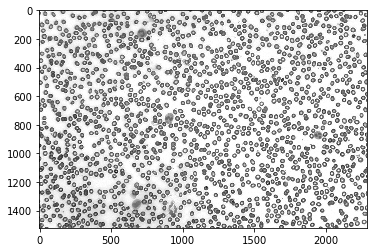

In [6]:
imshow(img_B,cmap='gray')

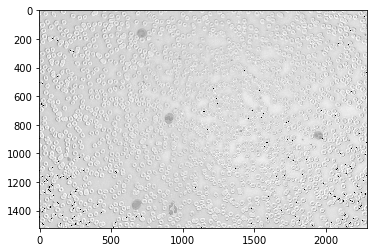

In [7]:
imshow(I_1,cmap='gray')

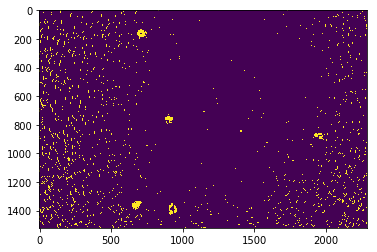

In [8]:
threshold_value = 180
ret, thresh = cv2.threshold(I_1, threshold_value, 255, cv2.THRESH_BINARY)
I_2 = np.invert(thresh)

imshow(I_2)

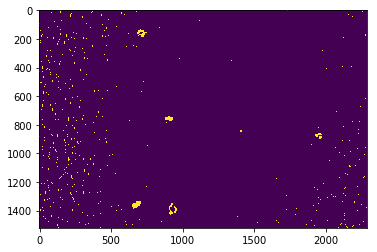

In [9]:
kernel_size_row = 3
kernel_size_col = 3
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size_row , kernel_size_col))

erosion = cv2.erode(I_2,kernel,iterations=1)

imshow(erosion)

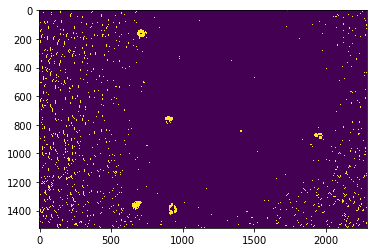

In [10]:
dilation = cv2.dilate(erosion,kernel,iterations=1)

imshow(dilation)

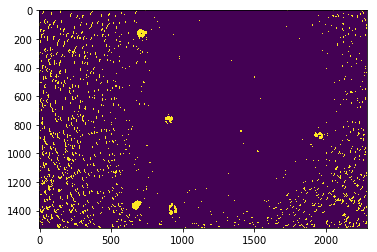

In [11]:
dilation = cv2.dilate(dilation,kernel,iterations=1)

imshow(dilation)

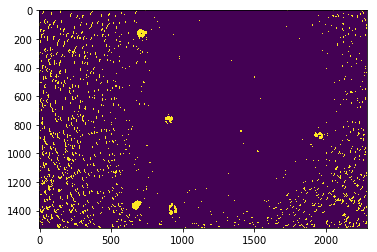

In [12]:
ret, dilation = cv2.threshold(dilation, 150, 255, cv2.THRESH_BINARY)

I_3 = dilation==I_2

imshow(dilation)

In [13]:
_, contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

original_img = img.copy()

center_array = []
xywh_array=[]

for cnt in contours:
    area = cv2.contourArea(cnt)
    
    if area > 20**2:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(original_img, (x,y), (x+w,y+h), (0,255,0), 2)
        
        center_array.append([x+w/2,y+h/2])
        xywh_array.append([x,y,w,h])

True

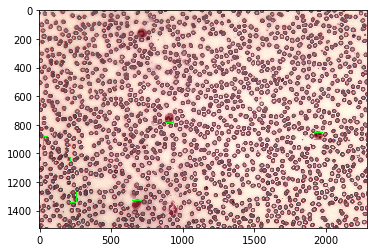

In [14]:
imshow(original_img)
cv2.imwrite('original_img.png', original_img)

In [15]:
break_bool =True
while break_bool:

    max_area = 0
    for x,y,w,h in xywh_array:
        if w*h > max_area:
            max_area = w*h
    
    break_bool=False
    for i in range(len(xywh_array)):
        for j in range(i+1,len(xywh_array)):

            cnt_1_center = [xywh_array[i][0]+xywh_array[i][2]/2,xywh_array[i][1]+xywh_array[i][3]/2]
            cnt_2_center = [xywh_array[j][0]+xywh_array[j][2]/2,xywh_array[j][1]+xywh_array[j][3]/2]

            center = [int((cnt_1_center[0]+cnt_2_center[0])/2),int((cnt_1_center[1]+cnt_2_center[1])/2)]

            distance = get_distance(cnt_1_center,cnt_2_center)
            union_area = get_union_area(xywh_array[i],xywh_array[j])
            

            if (distance<70) and (union_area<=max_area):


                New_start_x = min(xywh_array[i][0],xywh_array[j][0])
                New_start_y = min(xywh_array[i][1],xywh_array[j][1])
                New_end_x = max(xywh_array[i][0],xywh_array[j][0])
                New_end_y = max(xywh_array[i][1],xywh_array[j][1])

                New_w = max([center[0]-New_start_x,New_end_x-center[0]])*2
                New_h = max([center[1]-New_start_y,New_end_y-center[1]])*2

                xywh = get_marginal_xywh([center[0],center[1],0,0],[New_w/2,New_h/2],[img.shape[1],img.shape[0]])

                xywh_array.append(xywh)
                xywh_array.pop(j)
                xywh_array.pop(i)

                break_bool = True
                break
        if break_bool:
            break
    
            

In [16]:
final_img = img.copy()

for i in range(len(xywh_array)):
    x,y,w,h = xywh_array[i]
    cv2.rectangle(final_img, (x,y), (x+w,y+h), (0,255,0), 2)
    

True

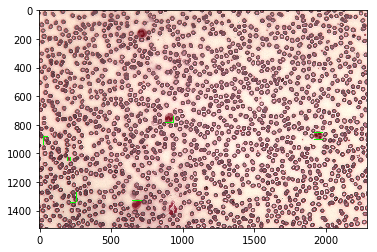

In [17]:
imshow(final_img)
cv2.imwrite('final_img.png', final_img)